<a href="https://colab.research.google.com/github/donbcolab/AIE3/blob/main/brain_tumor_hf_ds_alt_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Image Dataset - Hugging Face Dataset Creation

This notebook processes a brain tumor image dataset with COCO-format annotations and creates a Hugging Face Dataset.

Key learnings and decisions while creating this brain tumor image dataset for Hugging Face.

1. Data Structure:
   - The dataset contains brain tumor images with COCO-format annotations.
   - Annotations include bounding boxes and polygon segmentations.
   - Categories are structured as: ID 0 (Tumor), ID 1 (0), ID 2 (1), with 1 and 2 being subcategories of Tumor.

2. Segmentation Characteristics:
   - Segmentations are not rectangular but complex polygons.
   - 100% of segmentations are near their bounding boxes.
   - 100% of sampled annotations have valid polygon segmentations.

3. Key Adjustments:
   - We adjusted the 'features' definition to accommodate complex polygon segmentations.
   - The ClassLabel for 'category_id' was updated to ['Tumor', '0', '1'] to match the actual data structure.

4. Data Loading Considerations:
   - Image data is stored as bytes after being read with OpenCV.
   - Segmentation data needs to be carefully handled to maintain its list-of-lists structure.

5. Verification Steps:
   - We implemented functions to verify polygon validity and dataset structure.
   - These checks are crucial before pushing the dataset to the Hugging Face Hub.

6. Performance and Efficiency:
   - We used tqdm for progress tracking during image loading, which is helpful for large datasets.
   - The dataset creation process involves reading and encoding many images, which can be time-consuming.

7. Hugging Face Dataset Structure:
   - The dataset is created using the Hugging Face Datasets library, which has specific requirements for data types and structures.
   - We needed to ensure that all data types in the pandas DataFrame matched the defined features.

8. Potential Future Work:
   - The current implementation doesn't push to the Hugging Face Hub automatically. This step should be done manually after thorough verification.
   - Depending on the specific use case, additional preprocessing or data augmentation steps might be necessary.

## 1. Setup and Imports

This section imports necessary libraries and sets up the environment.


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
!pip install -qU pyarrow==14.0.1 requests==2.31.0

In [51]:
!pip install -qU datasets==2.11.0

In [52]:
import os
import json
import pandas as pd
from datasets import Dataset, Features, ClassLabel, Value, Sequence, Image
from tqdm.auto import tqdm
import cv2

## 2. Constants and Configuration
Define constants and configurations used throughout the notebook.


In [53]:
HF_DATASET_NAME = 'brain-tumor-image-dataset-semantic-segmentation-alt'
SOURCE_JSON = "/content/drive/MyDrive/kaggle/datasets/brain-tumor-image-dataset-semantic-segmentation/train/_annotations.coco.json"
SOURCE_IMAGE_DIR = "/content/drive/MyDrive/kaggle/datasets/brain-tumor-image-dataset-semantic-segmentation/train"


## 3. Feature Definition
Define the structure of the Hugging Face Dataset.

In [54]:
features = Features({
    'file_name': Value(dtype='string'),
    'image': Value(dtype='string'),  # Store image paths
    'id': Value(dtype='int64'),
    'category_id': ClassLabel(names=['Tumor', '0', '1']),  # Include 'Tumor' as category 0
    'bbox': Sequence(feature=Value(dtype='float32'), length=4),
    'segmentation': Sequence(Sequence(Value(dtype='float32'))),
    'area': Value(dtype='float32'),
    'iscrowd': Value(dtype='int64'),
    'height': Value(dtype='int64'),
    'width': Value(dtype='int64'),
    'date_captured': Value(dtype='string'),
    'license': Value(dtype='int64')
})

## 4. Data Loading and Preprocessing
Functions to load and preprocess the COCO-format data.

In [55]:
def verify_source_data():
    with open(SOURCE_JSON, 'r') as f:
        data = json.load(f)

    print("Categories:")
    for category in data['categories']:
        print(f"ID: {category['id']}, Name: {category['name']}, Supercategory: {category['supercategory']}")

    category_counts = pd.DataFrame(data['annotations'])['category_id'].value_counts().sort_index()
    print("\nCategory distribution in annotations:")
    print(category_counts)

    # Check for images with multiple bounding boxes
    image_bbox_counts = pd.DataFrame(data['annotations'])['image_id'].value_counts()
    print(f"\nImages with multiple bounding boxes: {(image_bbox_counts > 1).sum()}")
    print(f"Max bounding boxes in an image: {image_bbox_counts.max()}")

In [56]:
def load_data_to_df():
    with open(SOURCE_JSON, 'r') as f:
        data = json.load(f)

    images = pd.DataFrame(data['images'])
    annotations = pd.DataFrame(data['annotations'])

    df = pd.merge(images, annotations, left_on='id', right_on='image_id', suffixes=('', '_ann'))
    df = df.drop(columns=['id_ann', 'image_id'])

    # Store relative paths
    df['image'] = df['file_name'].apply(lambda x: os.path.join('images', x))

    # Inspect category_id values
    print("Unique category_id values:", df['category_id'].unique())
    print("Category_id value counts:\n", df['category_id'].value_counts())

    return df

## 5. Dataset Creation
Function to create the Hugging Face Dataset from the preprocessed data.

In [57]:
from PIL import Image as PILImage

def create_hf_dataset(df, hf_dataset_name):
    """Creates a Hugging Face Dataset from preprocessed data."""
    # Ensure datatypes match the features
    df['bbox'] = df['bbox'].apply(lambda x: [float(i) for i in x])
    df['segmentation'] = df['segmentation'].apply(lambda x: [[float(i) for i in poly] for poly in x])
    df['area'] = df['area'].astype('float32')

    # Create the dataset
    dataset = Dataset.from_pandas(df, features=features)
    print(f"Dataset created successfully with {len(dataset)} examples.")
    return dataset

## 6. Verification Functions
Functions to verify the integrity and structure of the data and created dataset.

In [58]:
import json
from collections import Counter

with open(SOURCE_JSON, 'r') as f:
    coco_data = json.load(f)

category_ids = [ann['category_id'] for ann in coco_data['annotations']]
id_counts = Counter(category_ids)

categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

print("Category ID counts:", id_counts)
print("Category mappings:", categories)

# Automated verification
expected_categories = {0: 'Tumor', 1: '0', 2: '1'}
assert categories == expected_categories, f"Category mismatch. Expected {expected_categories}, got {categories}"
assert set(id_counts.keys()) == {1, 2}, f"Unexpected category IDs found: {set(id_counts.keys())}"

Category ID counts: Counter({1: 771, 2: 731})
Category mappings: {0: 'Tumor', 1: '0', 2: '1'}


In [59]:
def is_valid_polygon(segmentation):
    # Check if it's a list of lists
    if not isinstance(segmentation, list) or not all(isinstance(poly, list) for poly in segmentation):
        return False

    # Check if each polygon has at least 6 coordinates (3 points)
    if not all(len(poly) >= 6 and len(poly) % 2 == 0 for poly in segmentation):
        return False

    return True

sample_annotations = coco_data['annotations'][:100]
valid_count = sum(is_valid_polygon(ann['segmentation']) for ann in sample_annotations)
valid_percentage = (valid_count / len(sample_annotations)) * 100
print(f"{valid_percentage:.2f}% of sampled annotations have valid polygon segmentations")

100.00% of sampled annotations have valid polygon segmentations


In [60]:
def verify_dataset(dataset):
    print(f"Dataset contains {len(dataset)} examples.")
    print("Sample of the first example:")
    print(dataset[0])

    # Check if all required fields are present
    required_fields = ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area']
    for field in required_fields:
        if field not in dataset[0]:
            print(f"Warning: '{field}' is missing from the dataset.")

    # Verify image data
    if isinstance(dataset[0]['image'], str):
        print("Image data is stored as file paths.")
    else:
        print("Warning: Image data is not stored as file paths.")

    # Verify segmentation data
    if isinstance(dataset[0]['segmentation'], list) and isinstance(dataset[0]['segmentation'][0], list):
        print("Segmentation data is stored as a list of lists.")
    else:
        print("Warning: Segmentation data is not stored as a list of lists.")

    print("Dataset verification complete.")

## 7. Main Execution
The main workflow to create and verify the dataset.

In [61]:
# Load and prepare the data
df = load_data_to_df()

# Create the dataset
dataset = create_hf_dataset(df, HF_DATASET_NAME)

# Verify the dataset
verify_dataset(dataset)

Unique category_id values: [1 2]
Category_id value counts:
 category_id
1    771
2    731
Name: count, dtype: int64
Dataset created successfully with 1502 examples.
Dataset contains 1502 examples.
Sample of the first example:
{'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg', 'image': 'images/2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg', 'id': 0, 'category_id': 1, 'bbox': [145.0, 239.0, 168.75, 162.5], 'segmentation': [[313.75, 238.75, 145.0, 238.75, 145.0, 401.25, 313.75, 401.25, 313.75, 238.75]], 'area': 27421.875, 'iscrowd': 0, 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00', 'license': 1}
Image data is stored as file paths.
Segmentation data is stored as a list of lists.
Dataset verification complete.


In [62]:
# Save the dataset to disk in Parquet format
dataset.save_to_disk(HF_DATASET_NAME)

Saving the dataset (0/1 shards):   0%|          | 0/1502 [00:00<?, ? examples/s]

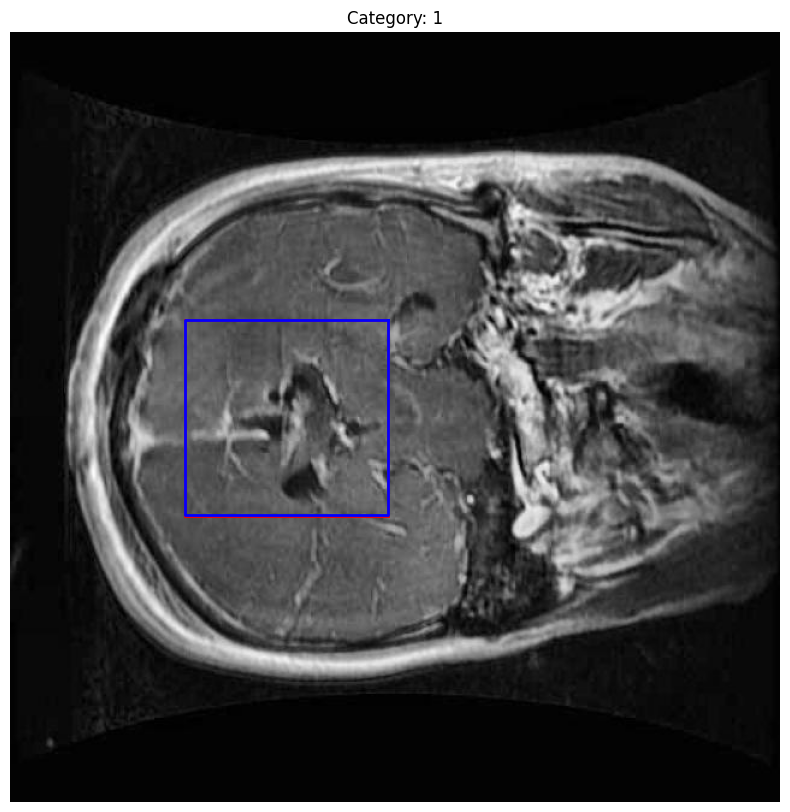

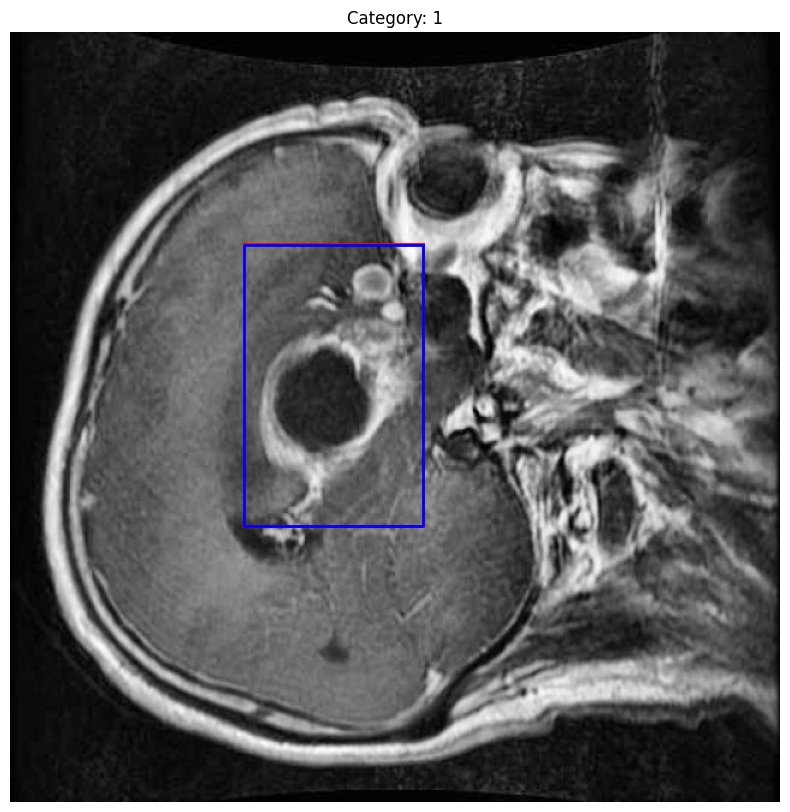

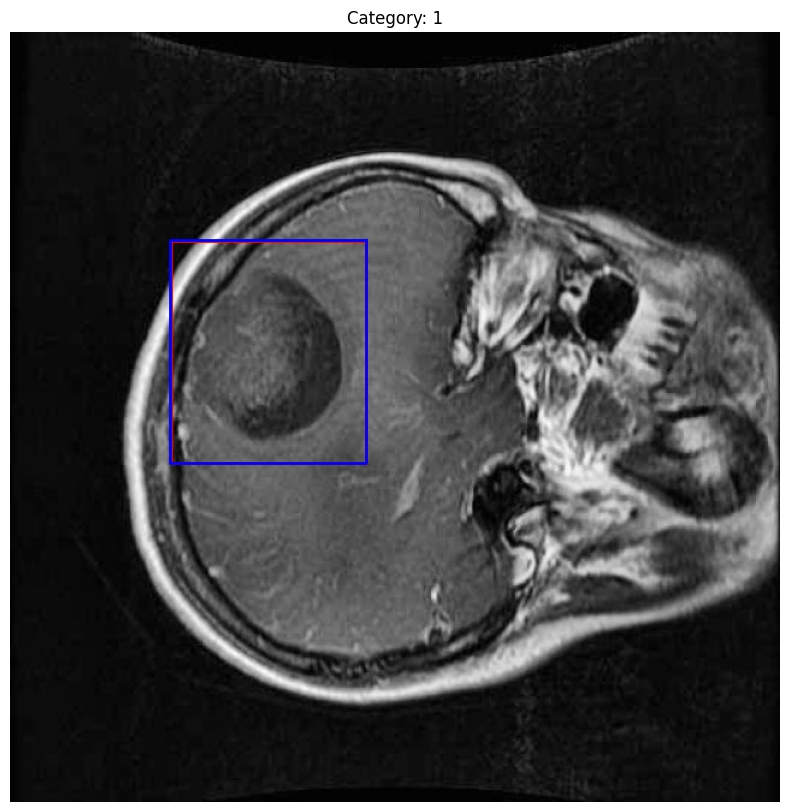

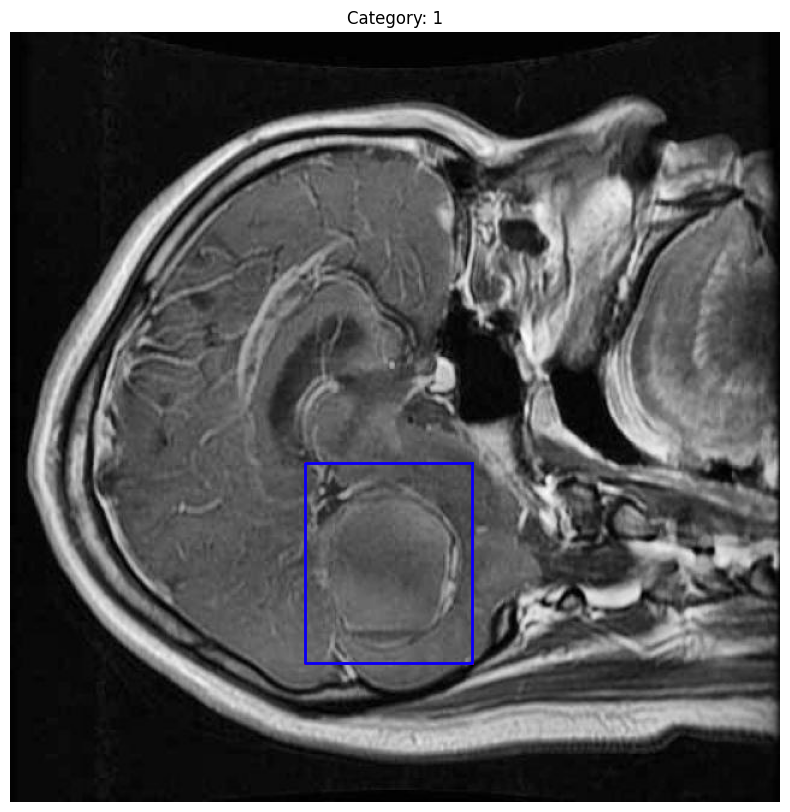

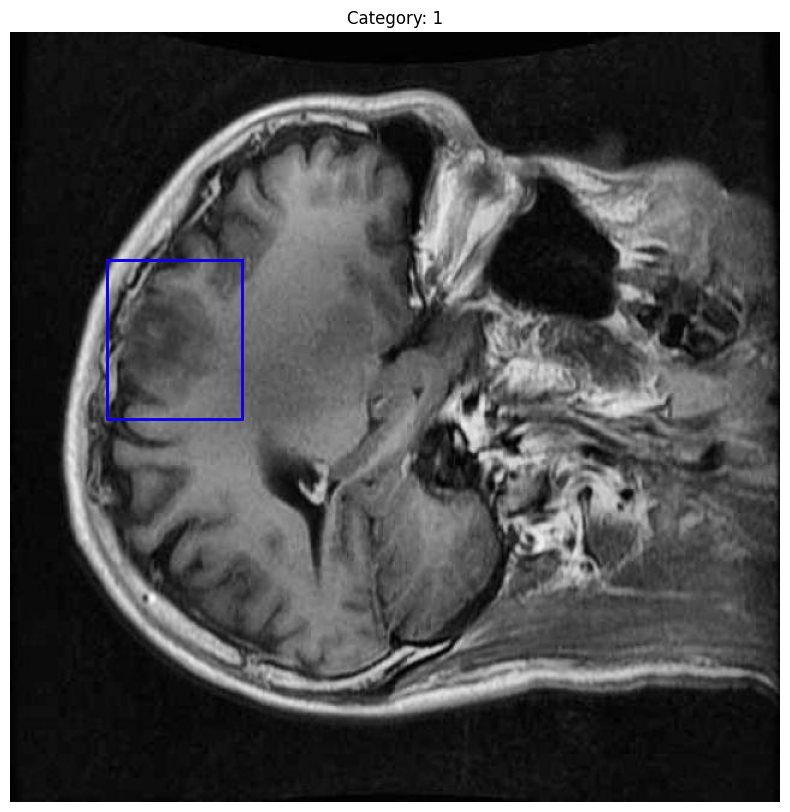

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_samples(dataset, num_samples=5):
    """Visualize a few sample images with annotations."""
    for i in range(num_samples):
        example = dataset[i]

        # Load image
        img = Image.open(os.path.join(SOURCE_IMAGE_DIR, example['file_name']))
        plt.figure(figsize=(10, 10))
        plt.imshow(img)

        # Draw bounding box
        bbox = example['bbox']
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

        # Draw segmentation
        seg = np.array(example['segmentation']).reshape(-1, 2)
        plt.plot(seg[:, 0], seg[:, 1], color='blue', linewidth=2)

        plt.title(f"Category: {example['category_id']}")
        plt.axis('off')
        plt.show()

# Call this function after dataset creation
visualize_samples(dataset)

## 8. (Optional) Upload to Hugging Face Hub
Uncomment this section when ready to upload the dataset to the Hugging Face Hub.

In [64]:
# Optional: Push to Hugging Face Hub
dataset.push_to_hub(HF_DATASET_NAME)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

In [65]:
display(df)

,id,license,file_name,height,width,date_captured,category_id,bbox,area,segmentation,iscrowd,image
0,0,1,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg,640,640,2023-08-19T04:37:54+00:00,1,"[145.0, 239.0, 168.75, 162.5]",27421.8750,"[[313.75, 238.75, 145.0, 238.75, 145.0, 401.25...",0,images/2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb92...
1,1,1,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg,640,640,2023-08-19T04:37:54+00:00,1,"[194.0, 176.0, 148.75, 233.75]",34770.3125,"[[342.5, 176.25, 193.75, 176.25, 193.75, 410.0...",0,images/2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406...
2,2,1,2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg,640,640,2023-08-19T04:37:54+00:00,1,"[133.0, 173.0, 162.5, 185.0]",30062.5000,"[[295.0, 172.5, 132.5, 172.5, 132.5, 357.5, 29...",0,images/2921_jpg.rf.3b952f91f27a6248091e7601c22...
3,3,1,2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg,640,640,2023-08-19T04:37:54+00:00,1,"[245.0, 358.0, 138.75, 166.25]",23067.1875,"[[383.75, 357.5, 245.0, 357.5, 245.0, 523.75, ...",0,images/2777_jpg.rf.3b60ea7f7e70552e70e41528052...
4,4,1,2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg,640,640,2023-08-19T04:37:54+00:00,1,"[80.0, 189.0, 112.5, 132.5]",14906.2500,"[[192.5, 188.75, 80.0, 188.75, 80.0, 321.25, 1...",0,images/2860_jpg.rf.3bb87fa4f938af5abfb1e17676e...
...,...,...,...,...,...,...,...,...,...,...,...,...
1497,1497,1,1365_jpg.rf.fe6ceef68f802f62e68bfe86cbedf4c0.jpg,640,640,2023-08-19T04:37:54+00:00,2,"[194.0, 264.0, 106.25, 122.5]",13015.6250,"[[300.0, 263.75, 193.75, 263.75, 193.75, 386.2...",0,images/1365_jpg.rf.fe6ceef68f802f62e68bfe86cbe...
1498,1498,1,2242_jpg.rf.ffaeadc4d4d6b67d5829ab30c8919708.jpg,640,640,2023-08-19T04:37:54+00:00,1,"[145.0, 305.0, 146.25, 145.0]",21206.2500,"[[291.25, 305.0, 145.0, 305.0, 145.0, 450.0, 2...",0,images/2242_jpg.rf.ffaeadc4d4d6b67d5829ab30c89...
1499,1499,1,2636_jpg.rf.ff6b7cbc4a4de3f93d813f6a7c04b4a8.jpg,640,640,2023-08-19T04:37:54+00:00,1,"[274.0, 133.0, 163.75, 173.75]",28451.5625,"[[437.5, 132.5, 273.75, 132.5, 273.75, 306.25,...",0,images/2636_jpg.rf.ff6b7cbc4a4de3f93d813f6a7c0...
1500,1500,1,147_jpg.rf.ff993da0adbed8883db143202e8c0e6e.jpg,640,640,2023-08-19T04:37:54+00:00,2,"[164.0, 311.0, 221.25, 213.75]",47292.1875,"[[385.0, 311.25, 163.75, 311.25, 163.75, 525.0...",0,images/147_jpg.rf.ff993da0adbed8883db143202e8c...
